In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import seaborn as sns

from lib.dummy_wordle_game import DummyWordleGame
from lib.player.bot_player import BotPlayer
from lib.words.simple_word_list import SimpleWordList
from lib.words.word_index import WordIndex
from lib.words.word_loader import WordLoader
from lib.stat_ranker import StatRanker
from lib.random_ranker import RandomRanker

In [14]:
import random

from lib.ranker_interface import RankerInterface

class StatRanker2(RankerInterface):
    AZ = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

    def __init__(self, wordlist, b=0):
        self.wordlist = list(wordlist)
        self.b = b
        self.update(wordlist)

    def rank(self, words):
        self.update(words)

        pairs = [(w, self.scores[w] + (random.random()*self.b)) for w in words]
        ranked = [pair[0] for pair in sorted(pairs, key=lambda x: x[1], reverse=True)]
        return ranked

    def update(self, wordlist):
        self.wordlist = list(wordlist)

        s = self._calculate_scores()
        self.scores = s
        None

    def _calculate_scores(self):
        
        freq = dict([(c, 0) for c in self.AZ])
        pfreq = dict([((i,c), 0) for i in range(5) for c in self.AZ])

        for w in self.wordlist:
            for i, l in enumerate(w):
                freq[l] += 1
                pfreq[(i,l)] += 1

        n = len(self.wordlist)

        scores = {}

        for c in self.AZ:
            freq[c] /= n
            for i in range(5): pfreq[(i,c)] /= n

        for w in self.wordlist:
            score = 0
            for i, l in enumerate(w):
                s = freq[l]
                ps = pfreq[(i,l)]
                
                score += s * ps
        
            scores[w] = score
            

        return scores

In [15]:
def get_stats(runs, words, ranker):
    wordlen = 5

    print('running games')
    guesses = []
    words = WordIndex(word_list)
    for i in range(runs):
        n_guesses = run_game(words, wordlen, ranker=ranker)
        guesses.append(n_guesses)
    return guesses

def run_game(words, wordlen=5, ranker=None):
    state = DummyWordleGame(words.list)
    ranker = ranker or RandomRanker(words.list)
    player = BotPlayer(state, words=words, ranker=ranker)
    result = None
    while True:
        guess = player.guess(state, prev=result)
        result = state.update(guess)

        if guess == state.answer:
            return state.guesses
        else:
            player.update_state(result)

running games
running games
running games


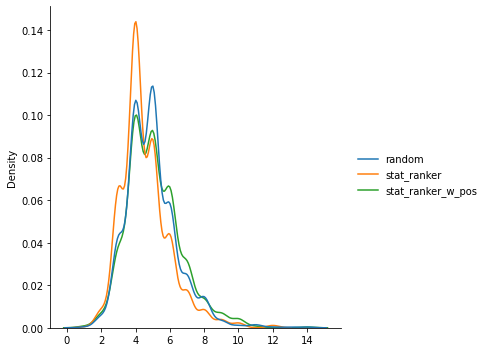

In [17]:
RUNS = 1000

word_list = WordLoader.load_wordlist(sample_size=10000)
    
rand_ranker = RandomRanker(word_list)
rand_stats = get_stats(RUNS, word_list, rand_ranker)

stat_ranker = StatRanker(word_list)
stat_stats = get_stats(RUNS, word_list, stat_ranker)

stat_ranker2 = StatRanker2(word_list)
stat_stats2 = get_stats(RUNS, word_list, stat_ranker2)


data = {
    "random": rand_stats,
    "stat_ranker": stat_stats,
    "stat_ranker_w_pos": stat_stats2
}

sns.displot(data, kind="kde")